<a href="https://colab.research.google.com/github/yandexdataschool/MLatImperial2020/blob/master/07_lab/GANs_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative adversarial networks

In [0]:
!wget https://github.com/yandexdataschool/MLatImperial2020/raw/master/07_lab/lfw_dataset.py

Let's do our usual imports + use a tool to download the dataset we'll use today:

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


from lfw_dataset import fetch_lfw_dataset
data, attrs = fetch_lfw_dataset(dimx=36, dimy=36)

So far our data has the following shape: (n_images, height, width, n_channels). PyTorch convolutional layers want the channels dimension to be the second one (axis=1), so let's transpose (and normalize) the data:

In [0]:
data = data.transpose(0, 3, 1, 2).astype(np.float32) / 255.

And here's a function to plot a (optionally random) subset of images:

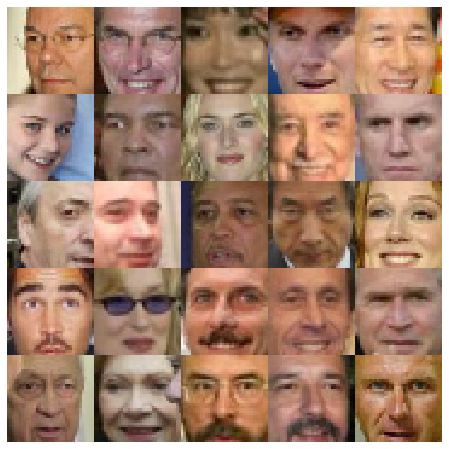

In [4]:
def plot_mn(images, m=5, n=5, shuffle=True):
  if shuffle:
    images = images[np.random.permutation(len(images))[:m * n]]
  h, w = images.shape[2:]
  images = images[:m*n].reshape(m, n, *images.shape[1:]).transpose(0, 1, 3, 4, 2)
  images = images.transpose(0, 2, 1, 3, 4).reshape(m * h, n * w, -1)
  plt.imshow(images)

plt.figure(figsize=(8, 8))
plot_mn(data)
plt.axis('off');

Our data shape is:

In [5]:
data.shape

(13143, 3, 36, 36)

Also, let's mount gdrive to save the models later on:

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Finally, let's import torch and define the Reshape layer (same as in the introduction to PyTorch):

In [0]:
import torch

class Reshape(torch.nn.Module):
  def __init__(self, *shape):
    super(Reshape, self).__init__()
    self.shape = shape

  def forward(self, x):
    return x.reshape(*self.shape)

Now, we'll take off from a very simple generator and discriminator:

In [0]:
latent_dims = 128
dropout_rate = 0.1

generator = torch.nn.Sequential(
    torch.nn.Linear(latent_dims, 64),
    torch.nn.ELU(),
    torch.nn.Dropout(p=dropout_rate),
    torch.nn.Linear(64, 3 * 36 * 36),
    torch.nn.ELU(),
    Reshape(-1, 3, 36, 36)
).cuda()

discriminator = torch.nn.Sequential(
    Reshape(-1, 3 * 36 * 36),
    torch.nn.Linear(3 * 36 * 36, 128),
    torch.nn.ELU(),
    torch.nn.Dropout(p=dropout_rate),
    torch.nn.Linear(128, 1),
).cuda()

def get_n_params(model):
  return sum(p.reshape(-1).shape[0] for p in model.parameters())

print('generator params:', get_n_params(generator))
print('discriminator params:', get_n_params(discriminator))

generator params: 260976
discriminator params: 497921


Then, we need a function to sample real and fake images:

In [0]:
def sample_images(batch_size):
  ids = np.random.choice(len(data), size=batch_size)
  return torch.tensor(data[ids]).cuda()

def sample_fake(batch_size):
  noise = torch.randn(batch_size, latent_dims).cuda()
  return generator(noise)

Let's have a look what we can generate before any training:

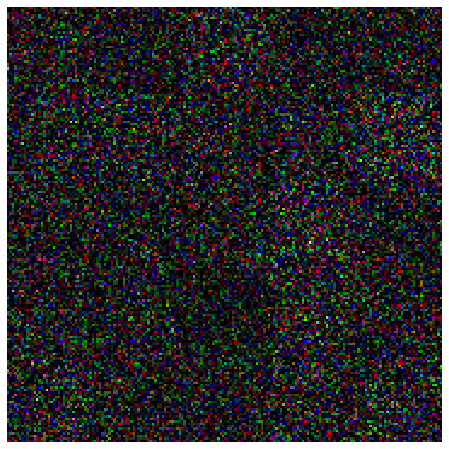

In [0]:
generator.eval()
imgs = sample_fake(25).cpu().detach().numpy()
plt.figure(figsize=(8, 8))
plot_mn(imgs.clip(0, 1))
plt.axis('off')
plt.show();

Ok, now that we have our model defined, we need our loss functions. Historically the first loss used in GANs is the cross-entropy that we already used so many times:
$$\mathscr{L}^{\text{discr}} =
-\text{E}\left[logD(x_{real})\right]
-\text{E}\left[log(1 - D(x_{fake}))\right] 
$$

And hence for the generator the loss is:

$$\mathscr{L}^{\text{gen}} =
-\text{E}\left[logD(x_{fake})\right]$$

Note that here $D(x)$ is the probability the discriminator assigns to $x$ to be from the real dataset, so it's $\sigma($ `discriminator` $(x))$.

Try implementing these loss functions below. Note that $1-\sigma(x)=\sigma(-x)$. You should use the `logsigmoid` as a stable realization of $log\cdot\sigma(x)$.

In [0]:
logsigmoid = torch.nn.functional.logsigmoid

def generator_loss(fake):
  return <YOUR CODE HERE>
  
def discriminator_loss(real, fake):
  return <YOUR CODE HERE>

In [0]:
### SOLUTION ###

logsigmoid = torch.nn.functional.logsigmoid

def generator_loss(fake):
  return -logsigmoid(discriminator(fake)).mean()
  
def discriminator_loss(real, fake):
  return -(logsigmoid(discriminator(real)) + logsigmoid(-discriminator(fake))).mean()

Let's do some more set-up and run the learning process:

In [0]:
batch_size = 32

generator_losses = []
discriminator_losses = []

In [0]:
optimizer_generator = \
    torch.optim.RMSprop(generator.parameters(), lr=0.001)
optimizer_discriminator = \
    torch.optim.RMSprop(discriminator.parameters(), lr=0.001)

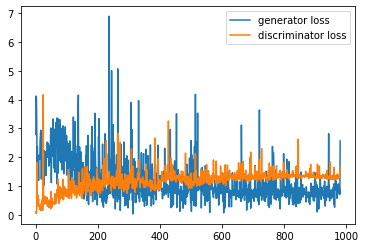

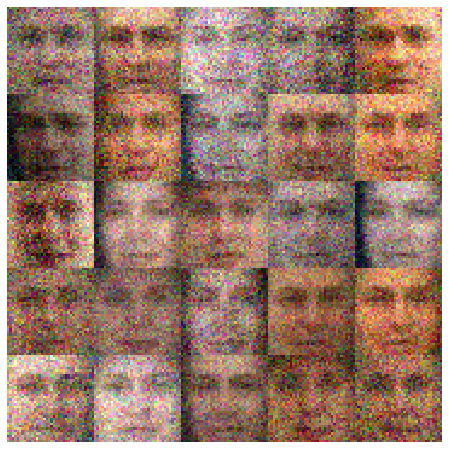

In [0]:
from IPython.display import clear_output


for i in range(1000):
  # Set our models to training mode:
  generator.train()
  discriminator.train()
  
  # Several discriminator updates per step:
  for j in range(5):
    # Sampling reals and fakes
    real = sample_images(batch_size)
    fake = sample_fake(batch_size)
    
    # Calculating the loss
    loss = discriminator_loss(real, fake)
    
    # Doing our regular optimization step for the discriminator
    discriminator.zero_grad()
    loss.backward()
    optimizer_discriminator.step()

  # Remember the value of discriminator loss for plotting
  discriminator_losses.append(loss.item())

  # Now it's generator's time to learn:
  loss = generator_loss(sample_fake(batch_size))
  generator_losses.append(loss.item())
  generator.zero_grad()
  loss.backward()
  optimizer_generator.step()

    
  if i % 20 == 0:
    clear_output(wait=True)
    plt.plot(generator_losses    , label='generator loss')
    plt.plot(discriminator_losses, label='discriminator loss')
    plt.legend()
    plt.show()
    generator.eval()
    imgs = sample_fake(25).cpu().detach().numpy()
    plt.figure(figsize=(8, 8))
    plot_mn(imgs.clip(0, 1))
    plt.axis('off')
    plt.show();

Seems like it's working! Now try to impelment some convolutional architechtures to make our model more expressive.

You might face some instabilities as you go. The simplest regularization that can be done is **adding some random noize to the discriminator's input**.

Another good stabilization is adding a **discriminator gradient L2 penalty for real images only** (see this paper: https://arxiv.org/pdf/1801.04406.pdf):

```
def discriminator_penalty(real):
  real.requires_grad = True
  scores = discriminator(real)
  grad_params = torch.autograd.grad(scores.mean(), real,
                                    create_graph=True)
  penalty = sum((grad**2).sum() for grad in grad_params)
  return penalty
```


You can also use **decreasing learning rate**:

```
# multiply the learning rate by 0.999 each 10 steps:
scheduler_d = torch.optim.lr_scheduler.StepLR(optimizer_discriminator, step_size=10, gamma=0.999)
scheduler_g = torch.optim.lr_scheduler.StepLR(optimizer_generator    , step_size=10, gamma=0.999)

# ...

# In the training loop:
  scheduler_d.step()
  scheduler_g.step()
```

In [55]:
### SOLUTION ###

latent_dims = 128
dropout_rate = 0.1

generator = torch.nn.Sequential(
    Reshape(-1, 8, 4, 4),
    torch.nn.Conv2d(8, 128, 2), # 128x3x3
    torch.nn.ELU(),
    torch.nn.Dropout(dropout_rate),
    torch.nn.Upsample((6, 6)), # 128x6x6

    torch.nn.Conv2d(128, 128, 3), # 128x4x4
    torch.nn.ELU(),
    torch.nn.Dropout(dropout_rate),
    torch.nn.Upsample((8, 8)), # 128x8x8

    torch.nn.Conv2d(128, 64, 3), # 64x6x6
    torch.nn.ELU(),
    torch.nn.Dropout(dropout_rate),
    torch.nn.Upsample((12, 12)), # 64x12x12

    torch.nn.Conv2d(64, 64, 3), # 64x10x10
    torch.nn.ELU(),
    torch.nn.Dropout(dropout_rate),
    torch.nn.Upsample((20, 20)), # 64x20x20

    torch.nn.Conv2d(64, 32, 2), # 32x19x19
    torch.nn.ELU(),
    torch.nn.Dropout(dropout_rate),
    torch.nn.Upsample((38, 38)), # 32x38x38

    torch.nn.Conv2d(32, 8, 3), # 8x36x36
    torch.nn.ELU(),
    torch.nn.Dropout(dropout_rate),

    torch.nn.Conv2d(8, 3, 1), # 3x36x36
    torch.nn.ELU(),
).cuda()

discriminator = torch.nn.Sequential(
    torch.nn.Conv2d(3, 8, 3, padding=1), # 8x36x36
    torch.nn.ELU(),
    torch.nn.Dropout(dropout_rate),
    torch.nn.MaxPool2d(2), # 8x18x18

    torch.nn.Conv2d(8, 16, 3, padding=0), # 16x16x16
    torch.nn.ELU(),
    torch.nn.Dropout(dropout_rate),
    torch.nn.MaxPool2d(2), # 16x8x8

    torch.nn.Conv2d(16, 64, 3, padding=1), # 64x8x8
    torch.nn.ELU(),
    torch.nn.Dropout(dropout_rate),
    torch.nn.MaxPool2d(2), # 64x4x4

    torch.nn.Conv2d(64, 256, 3, padding=1), # 256x4x4
    torch.nn.ELU(),
    torch.nn.Dropout(dropout_rate),
    torch.nn.MaxPool2d(2), # 256x2x2

    Reshape(-1, 256 * 2 * 2),
    torch.nn.Linear(1024, 1),
).cuda()

def get_n_params(model):
  return sum(p.reshape(-1).shape[0] for p in model.parameters())

print('generator params:', get_n_params(generator))
print('discriminator params:', get_n_params(discriminator))


generator params: 273091
discriminator params: 159409


In [0]:
def sample_images(batch_size):
  ids = np.random.choice(len(data), size=batch_size)
  return torch.tensor(data[ids]).cuda()

def sample_fake(batch_size):
  noise = torch.randn(batch_size, latent_dims).cuda()
  return generator(noise)

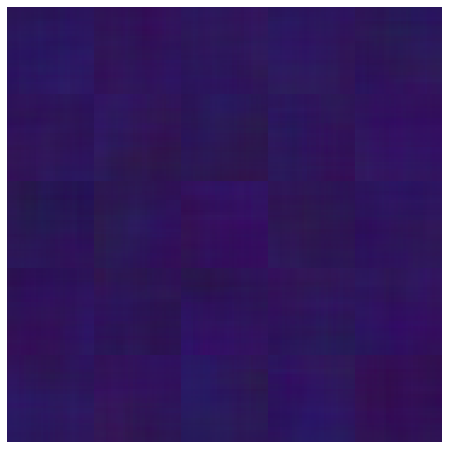

In [57]:
generator.eval()
imgs = sample_fake(25).cpu().detach().numpy()
plt.figure(figsize=(8, 8))
plot_mn(imgs.clip(0, 1))
plt.axis('off')
plt.show();

In [0]:
### SOLUTION ###

# What we're implementing here is actually Wasserstein loss from this
# paper https://arxiv.org/abs/1704.00028
#
# This loss has some nicer properties compared to our initial cross-entropy
# loss above, e.g. it helps to solve the mode collapse problem. See this
# post for more information https://medium.com/@jonathan_hui/gan-wasserstein-gan-wgan-gp-6a1a2aa1b490

def generator_loss(fake):
  return discriminator(fake).mean()


def gradient_penalty(real, fake):
  alpha = torch.rand(real.shape[0], 1, 1, 1).to(real.device)
  real.requires_grad = True
  interp = alpha * real + (1 - alpha) * fake

  scores = discriminator(interp)
  grads, = torch.autograd.grad(scores.sum(), interp,
                               create_graph=True)
  
  penalty = (((grads.view(grads.shape[0], -1)**2).sum(dim=-1)**0.5 - 1)**2).mean()
  return penalty

def discriminator_loss(real, fake):
  return (discriminator(real) - discriminator(fake)).mean() + 10 * gradient_penalty(real, fake)

In [0]:
batch_size = 32

generator_losses = []
discriminator_losses = []

In [0]:
optimizer_generator = \
    torch.optim.RMSprop(generator.parameters(), lr=0.001)
optimizer_discriminator = \
    torch.optim.RMSprop(discriminator.parameters(), lr=0.001)

scheduler_d = torch.optim.lr_scheduler.StepLR(optimizer_discriminator, step_size=100, gamma=0.999)
scheduler_g = torch.optim.lr_scheduler.StepLR(optimizer_generator    , step_size=100, gamma=0.999)

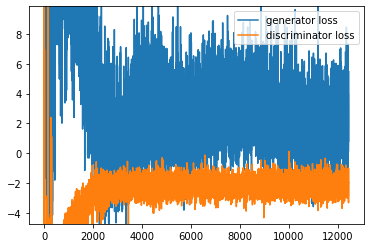

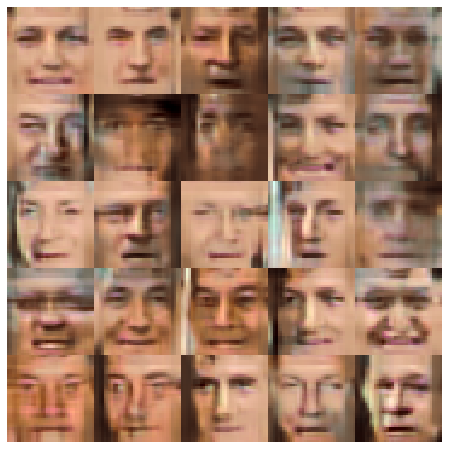

In [0]:
from IPython.display import clear_output

for i in range(20000):
  # Set our models to training mode:
  generator.train()
  discriminator.train()
  
  # Several discriminator updates per step:
  for j in range(5):
    # Sampling reals and fakes
    real = sample_images(batch_size)
    fake = sample_fake(batch_size)
    
    # Calculating the loss
    loss = discriminator_loss(real, fake)
    
    # Doing our regular optimization step for the discriminator
    discriminator.zero_grad()
    loss.backward()
    optimizer_discriminator.step()

  # Remember the value of discriminator loss for plotting
  discriminator_losses.append(loss.item())

  # Now it's generator's time to learn:
  loss = generator_loss(sample_fake(batch_size))
  generator_losses.append(loss.item())
  generator.zero_grad()
  loss.backward()
  optimizer_generator.step()


  scheduler_d.step()
  scheduler_g.step()

  if i % 20 == 0:
    clear_output(wait=True)
    plt.plot(generator_losses    , label='generator loss')
    plt.plot(discriminator_losses, label='discriminator loss')
    plt.ylim(*(np.quantile(discriminator_losses + generator_losses, (0.05, 0.95)) * 1.1))
    plt.legend()
    plt.show()
    generator.eval()
    imgs = sample_fake(25).cpu().detach().numpy()
    plt.figure(figsize=(8, 8))
    plot_mn(imgs.clip(0, 1))
    plt.axis('off')
    plt.show();